# Building Morphology (3D)

This notebook analyses building morphology metrics from EUBUCCO data to support Urban Heat Island (UHI) prediction modelling across study cities.

## Overview

- **Source**: EUBUCCO building database (206M buildings across Europe)
- **Processing**: Clipped to study area boundaries using ogr2ogr
- **Format**: GeoPackage (.gpkg) files in EPSG:3857 (Web Mercator)
- **Cities**: Amsterdam, Athens, Barcelona, Berlin, Madrid, Paris

## Key Analyses
- Building morphology metrics calculation
- Height and age attribute analysis
- Grid integration with weighted aggregation
- Export for machine learning pipeline

## 1. Setup and Configuration

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
import momepy
import matplotlib as mpl
import contextily as ctx
import mapclassify
from matplotlib.colors import BoundaryNorm, ListedColormap
import sys

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Configuration
CITIES = ['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Madrid', 'Paris']
BUILDINGS_DIR = Path('../data/1-processed/Buildings')
DATA_DIR = BUILDINGS_DIR
GRID_ROOT = Path('../data/utils/grids')
TARGET_CRS = 'EPSG:3857'
METRIC_CRS = 'EPSG:3035'
GRID_RESOLUTIONS = [30, 60, 90]
FLOOR_HEIGHT_METERS = 3.5

if not BUILDINGS_DIR.exists():
    raise FileNotFoundError(f"Building inputs missing: {BUILDINGS_DIR}. Run the preprocessing pipeline or place *_buildings.gpkg files there.")

plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore', category=UserWarning)

FIG_DIR = PROJECT_ROOT / 'results' / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)



## 2. Data Loading

In [3]:
def load_building_footprints():
    """Load building footprint data for all study cities"""
    city_buildings = {}
    gpkg_files = sorted(DATA_DIR.glob("*_buildings.gpkg"))
    if not gpkg_files:
        raise FileNotFoundError(f"No building files found in {DATA_DIR}")

    for file_path in gpkg_files:
        city = file_path.stem.replace('_buildings', '').title()
        try:
            gdf = gpd.read_file(file_path)
            if gdf.crs is None:
                raise ValueError(f"{file_path.name} has no CRS defined; unable to compute areas")
            gdf = gdf.dropna(subset=['geometry']).loc[~gdf.geometry.is_empty].copy()
            gdf['height'] = pd.to_numeric(gdf.get('height'), errors='coerce')
            gdf['city'] = city
            city_buildings[city] = gdf

            n = len(gdf)
            n_h = gdf['height'].notnull().sum()
            pct_height = (n_h / n * 100) if n else 0
            print(f"Loaded {city}: {n:,} buildings ({pct_height:.1f}% with height)")
        except Exception as e:
            warnings.warn(f"Error loading {city}: {e}")

    total_buildings = sum(len(g) for g in city_buildings.values())
    print(f"Total buildings: {total_buildings:,}")
    return city_buildings

city_buildings = load_building_footprints()

Loaded Amsterdam: 6,497 buildings (100.0% with height)
Loaded Athens: 8,568 buildings (100.0% with height)
Loaded Barcelona: 3,715 buildings (100.0% with height)
Loaded Berlin: 930 buildings (100.0% with height)
Loaded Madrid: 1,524 buildings (100.0% with height)
Loaded Paris: 5,219 buildings (100.0% with height)
Total buildings: 26,453


Saved building height figure to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/diagnostics/buildings/building_heights.png
Saved panel figure to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/figures/buildings_height_panels.png


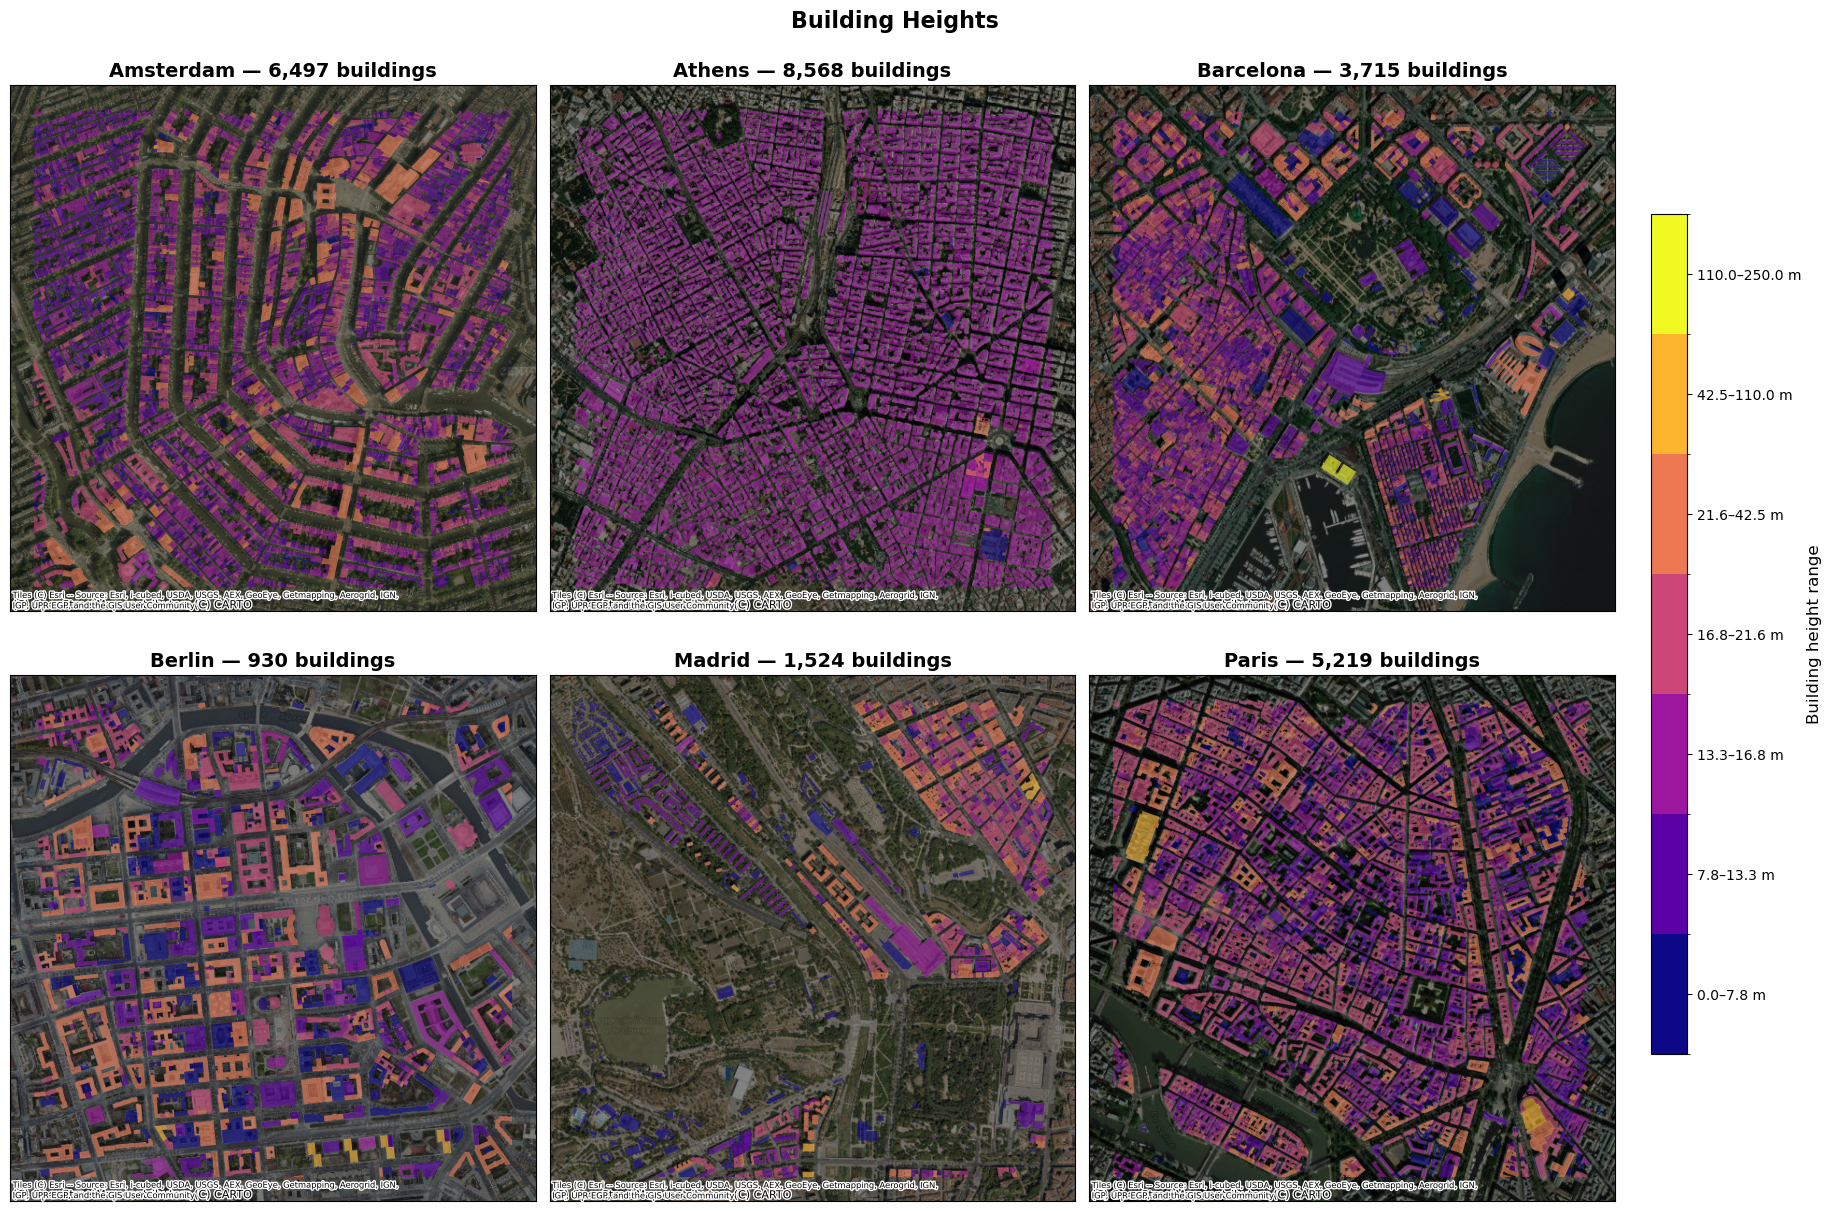

In [4]:
# Spatial visualisation: Building footprints with height mapping using natural breaks and a perceptually uniform color ramp
height_series = pd.concat(
    [gdf['height'].dropna() for gdf in city_buildings.values()],
    ignore_index=True
) if city_buildings else pd.Series(dtype=float)

if height_series.empty or height_series.nunique() < 2:
    print("Insufficient non-null building heights to produce natural-breaks visualisation.")
else:
    n_classes = min(7, height_series.nunique())
    classifier = mapclassify.NaturalBreaks(height_series, k=n_classes)
    height_boundaries = np.concatenate(([float(height_series.min())], classifier.bins))
    norm = BoundaryNorm(np.arange(-0.5, n_classes + 0.5, 1), n_classes)
    cmap = mpl.colormaps['plasma'].resampled(n_classes)
    listed_cmap = ListedColormap([cmap(i) for i in range(n_classes)])

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    last_idx = -1
    for idx, (city, gdf) in enumerate(city_buildings.items()):
        last_idx = idx
        if idx >= len(axes):
            break
        ax = axes[idx]
        gdf_plot = gdf.to_crs(TARGET_CRS) if gdf.crs != TARGET_CRS else gdf.copy()
        heights = gdf_plot['height'].fillna(height_series.min())
        height_bins = classifier.find_bin(heights).astype(float)
        height_bins[gdf_plot['height'].isna()] = np.nan
        gdf_plot['height_bin'] = height_bins

        gdf_plot[gdf_plot['height_bin'].notna()].plot(
            ax=ax,
            column='height_bin',
            cmap=listed_cmap,
            linewidth=0.1,
            edgecolor='none',
            alpha=0.6,
            vmin=0,
            vmax=n_classes - 1,
        )
        gdf_plot[gdf_plot['height_bin'].isna()].plot(
            ax=ax,
            color='lightgrey',
            linewidth=0.1,
            edgecolor='none',
            alpha=0.3,
        )

        try:
            ctx.add_basemap(ax, crs=gdf_plot.crs, source=ctx.providers.CartoDB.DarkMatter)
            ctx.add_basemap(ax, crs=gdf_plot.crs, source=ctx.providers.Esri.WorldImagery, alpha=0.5, attribution_size=6)
        except Exception as exc:
            if idx == 0:
                warnings.warn(f"Basemap tiles unavailable; rendering without imagery ({exc}).")

        ax.set_title(f"{city} — {len(gdf_plot):,} buildings", fontsize=14, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])

    for ax in axes[last_idx + 1:]:
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle('Building Heights', fontsize=16, fontweight='bold', y=1.02)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = mpl.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
    sm._A = []
    tick_positions = np.arange(n_classes)
    bin_labels = [f"{height_boundaries[i]:.1f}–{height_boundaries[i + 1]:.1f}" for i in range(n_classes)]
    cbar = fig.colorbar(sm, cax=cbar_ax, boundaries=np.arange(-0.5, n_classes + 0.5, 1), ticks=tick_positions)
    cbar.ax.set_yticklabels([f"{label} m" for label in bin_labels])
    cbar.set_label('Building height range', fontsize=12)

    plt.subplots_adjust(right=0.9)
    output_dir = PROJECT_ROOT / 'results' / 'diagnostics' / 'buildings'
    output_dir.mkdir(parents=True, exist_ok=True)
    figure_path = output_dir / 'building_heights.png'
    fig_path = FIG_DIR / 'buildings_height_panels.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f'Saved building height figure to {figure_path}')
    print(f'Saved panel figure to {fig_path}')
    plt.show()

In [5]:
# Summary table by city
summary = city_buildings.copy()
for city in summary:
    gdf = summary[city]
    height_values = pd.to_numeric(gdf['height'], errors='coerce')
    age_values = pd.to_numeric(gdf['age'], errors='coerce')
    
    summary[city] = {
        'N of buildings': len(gdf),
        'Mean Height (m)': height_values.mean(),
        'Std Height (m)': height_values.std(),
        'Mean Age (years)': age_values.mean(),
        'Std Age (years)': age_values.std()
    }

summary_df = pd.DataFrame(summary).T.round(1)
summary_df.index.name = 'City'
summary_df

N of buildings  Mean Height (m)  Std Height (m)  Mean Age (years)  \
City                                                                           
Amsterdam          6497.0             13.6             4.1            1368.6   
Athens             8568.0             15.0             0.9            1856.3   
Barcelona          3715.0             14.8             6.2            1913.3   
Berlin              930.0             15.9             9.8               NaN   
Madrid             1524.0             13.7             7.5            1956.0   
Paris              5219.0             15.9             5.6            1837.7   

           Std Age (years)  
City                        
Amsterdam            437.4  
Athens                37.8  
Barcelona             57.1  
Berlin                 NaN  
Madrid                26.8  
Paris                 98.1

## 3. Building Morphology Metrics

We export five groups of metrics so downstream notebooks have consistent inputs aligned with current UHI literature:

- **Core mass & coverage:** building count, total footprint & wall surface area, FAR, BVD, area-weighted height, coverage ratio, plan porosity.
- **Height texture:** weighted height std/p10/p90/range/relative, aspect ratio, compactness.
- **Thermal & roughness proxies:** wall-to-plan ratio, frontal area index, surface-to-volume ratio, thermal mass index, directional frontal-area densities (N–S / E–W).
- **Canyon openness:** façade orientation entropy, canyon width, courtyard fraction.
- **Building age mix:** weighted building year plus pre-1950, 1950–1990, and post-1990 shares.

Each metric is computed per grid cell after clipping footprints to the standardised 30×30 m grid so the exports align with the modelling resolution.


In [6]:
def calculate_morphology_metrics(buildings_gdf):
    """Calculate morphology metrics for UHI prediction"""
    if buildings_gdf.empty:
        return buildings_gdf.assign(
            area_m2=0.0,
            perimeter_m=0.0,
            wall_surface_area=0.0,
            floors=np.nan,
            floor_area_m2=0.0,
            volume_m3=0.0,
            aspect_ratio=np.nan,
            compactness=np.nan,
            orientation_deg=np.nan,
            canyon_width=np.nan,
            has_courtyard=0,
            building_year=np.nan,
            building_age_years=np.nan,
            age_pre1950=0,
            age_1950_1990=0,
            age_post1990=0
        )

    gdf = buildings_gdf.copy()
    metric_gdf = gdf.to_crs(METRIC_CRS)

    gdf['area_m2'] = metric_gdf.geometry.area
    gdf['perimeter_m'] = metric_gdf.geometry.length

    heights = pd.to_numeric(gdf.get('height'), errors='coerce')
    gdf['height'] = heights

    def _orientation_from_geom(geom):
        try:
            mrr = geom.minimum_rotated_rectangle
            coords = list(mrr.exterior.coords)
            edge = np.array(coords[1]) - np.array(coords[0])
            angle = np.degrees(np.arctan2(edge[1], edge[0])) % 180
            return angle
        except Exception:
            return np.nan

    gdf['orientation_deg'] = metric_gdf.geometry.apply(_orientation_from_geom)
    gdf['has_courtyard'] = metric_gdf.geometry.apply(lambda geom: 1 if hasattr(geom, 'interiors') and len(geom.interiors) > 0 else 0)

    gdf['wall_surface_area'] = np.where(heights.notnull(),
                                        gdf['perimeter_m'] * heights,
                                        0.0)

    def _orientation_bin(angle):
        if pd.isna(angle):
            return 'unknown'
        angle = angle % 180
        return 'ns' if angle <= 45 or angle >= 135 else 'ew'

    gdf['orientation_bin'] = gdf['orientation_deg'].apply(_orientation_bin)
    gdf['wall_surface_area_ns'] = np.where(gdf['orientation_bin'] == 'ns', gdf['wall_surface_area'], 0.0)
    gdf['wall_surface_area_ew'] = np.where(gdf['orientation_bin'] == 'ew', gdf['wall_surface_area'], 0.0)

    gdf['floors'] = np.where(heights.notnull(), np.ceil(heights / FLOOR_HEIGHT_METERS), np.nan)
    gdf['floor_area_m2'] = gdf['area_m2'] * gdf['floors']
    gdf['volume_m3'] = gdf['area_m2'] * heights

    valid_area = gdf['area_m2'] > 0
    gdf['aspect_ratio'] = np.where(heights.notnull() & valid_area, heights / np.sqrt(gdf['area_m2']), np.nan)
    gdf['canyon_width'] = np.where(gdf['perimeter_m'] > 0, (4 * gdf['area_m2']) / gdf['perimeter_m'], np.nan)

    try:
        gdf['compactness'] = momepy.circular_compactness(metric_gdf).series
    except Exception:
        gdf['compactness'] = np.where(
            gdf['perimeter_m'] > 0,
            gdf['area_m2'] / (gdf['perimeter_m'] ** 2),
            np.nan
        )

    current_year = pd.Timestamp.today().year
    building_year = pd.to_numeric(gdf.get('age'), errors='coerce')
    building_year = building_year.where((building_year >= 1200) & (building_year <= current_year), np.nan)
    gdf['building_year'] = building_year
    gdf['building_age_years'] = np.where(building_year.notnull(), current_year - building_year, np.nan)
    gdf['age_pre1950'] = np.where((building_year.notnull()) & (building_year < 1950), 1, 0)
    gdf['age_1950_1990'] = np.where((building_year.notnull()) & (building_year >= 1950) & (building_year < 1990), 1, 0)
    gdf['age_post1990'] = np.where((building_year.notnull()) & (building_year >= 1990), 1, 0)

    return gdf


## 4. Grid Integration

Spatially integrate building morphology metrics into standardised 30m×30m grid cells following the pattern used in GlobalStreetscapes and Urbanity notebooks.

In [7]:
def clip_buildings_to_grid(buildings_gdf, city_grid, city_name):
    """Clip footprints to the grid extent so per-cell areas stay bounded."""
    if buildings_gdf.empty:
        return gpd.GeoDataFrame(columns=buildings_gdf.columns, crs=city_grid.crs)
    buildings_local = buildings_gdf.to_crs(city_grid.crs) if buildings_gdf.crs != city_grid.crs else buildings_gdf.copy()
    grid_cells = city_grid[['global_grid_id', 'geometry']]
    try:
        overlay = gpd.overlay(buildings_local, grid_cells, how='intersection', keep_geom_type=False)
    except Exception as exc:
        warnings.warn(f"Overlay failed for {city_name}: {exc}")
        return gpd.GeoDataFrame(columns=buildings_gdf.columns, crs=city_grid.crs)
    rename_map = {'global_grid_id_2': 'global_grid_id', 'city_2': 'city'}
    overlay = overlay.rename(columns={k: v for k, v in rename_map.items() if k in overlay.columns})
    overlay = overlay.drop(columns=['index_left', 'index_right', 'global_grid_id_1', 'city_1'], errors='ignore')
    return overlay[overlay['geometry'].notna() & ~overlay.geometry.is_empty]


In [8]:
def _orientation_entropy(group):
    orient = group['orientation_deg'].dropna()
    if orient.empty:
        return 0.0
    weights = group.loc[orient.index, 'area_m2'].fillna(0)
    bins = np.linspace(0, 180, 9)
    hist = np.zeros(len(bins) - 1)
    inds = np.digitize(orient, bins, right=False) - 1
    for idx, w in zip(inds, weights):
        if 0 <= idx < len(hist):
            hist[idx] += w
    total = hist.sum()
    if total <= 0:
        return 0.0
    probs = hist / total
    probs = probs[probs > 0]
    return float(-(probs * np.log(probs)).sum())
def _area_weighted_mean(group, value_col, weight_col='area_m2'):
    mask = group[value_col].notna()
    if not mask.any():
        return np.nan
    weights = group.loc[mask, weight_col].fillna(0)
    values = group.loc[mask, value_col]
    total_weight = weights.sum()
    return (values * weights).sum() / total_weight if total_weight > 0 else np.nan
def _area_weighted_std(group, value_col, weight_col='area_m2'):
    weights = group[weight_col].fillna(0)
    values = group[value_col].fillna(0)
    total_weight = weights.sum()
    if total_weight <= 0 or len(group) <= 1:
        return 0.0
    weighted_mean = (values * weights).sum() / total_weight
    variance = (weights * (values - weighted_mean) ** 2).sum() / total_weight
    return np.sqrt(variance)



In [9]:
def compute_grid_metric_records(clipped_buildings, city_grid):
    if clipped_buildings.empty:
        return []
    buildings_with_metrics = calculate_morphology_metrics(clipped_buildings)
    grid_metric = city_grid.to_crs(METRIC_CRS)
    grid_area_lookup = grid_metric.set_index('global_grid_id').geometry.area.to_dict()
    agg_records = []
    for grid_id, group in buildings_with_metrics.groupby('global_grid_id'):
        cell_area = grid_area_lookup.get(grid_id)
        if cell_area is None or pd.isna(cell_area) or cell_area <= 0:
            continue
        heights = group['height'].dropna()
        height_mean = _area_weighted_mean(group, 'height')
        height_median = float(np.median(heights)) if len(heights) else 0.0
        total_footprint = group['area_m2'].sum()
        total_wall_surface = group['wall_surface_area'].sum()
        total_volume = group['volume_m3'].sum()
        total_floor_area = group['floor_area_m2'].sum()
        coverage_geom = gpd.GeoSeries(group['geometry'], crs=city_grid.crs)
        coverage_geom = coverage_geom.to_crs(METRIC_CRS)
        plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0
        plan_coverage = plan_coverage_area / cell_area if cell_area > 0 else 0.0
        wall_to_plan = float(total_wall_surface / total_footprint) if total_footprint > 0 else 0.0
        metrics = {
            'global_grid_id': grid_id,
            'building_count': len(group),
            'total_footprint_area': total_footprint,
            'total_wall_surface_area': total_wall_surface,
            'FAR': total_floor_area / cell_area if cell_area > 0 else 0.0,
            'BVD': total_volume / cell_area if cell_area > 0 else 0.0,
            'area_weighted_height': height_mean,
            'building_coverage_ratio': plan_coverage,
            'plan_porosity': max(0.0, 1.0 - plan_coverage),
            'height_std_weighted': _area_weighted_std(group, 'height'),
            'height_p10': float(np.percentile(heights, 10)) if len(heights) else 0.0,
            'height_p90': float(np.percentile(heights, 90)) if len(heights) else 0.0,
            'height_range': float(heights.max() - heights.min()) if len(heights) else 0.0,
            'height_relative': float(height_mean - height_median),
            'aspect_ratio_weighted': _area_weighted_mean(group, 'aspect_ratio'),
            'compactness_weighted': _area_weighted_mean(group, 'compactness'),
            'wall_to_plan_ratio': wall_to_plan,
            'frontal_area_index': total_wall_surface / cell_area if cell_area > 0 else 0.0,
            'surface_to_volume_ratio': total_wall_surface / total_volume if total_volume > 0 else 0.0,
            'thermal_mass_index': total_floor_area / total_volume if total_volume > 0 else 0.0,
            'facade_orientation_entropy': _orientation_entropy(group),
            'canyon_width_mean': _area_weighted_mean(group, 'canyon_width'),
            'courtyard_fraction': _area_weighted_mean(group, 'has_courtyard'),
            'area_weighted_building_year': _area_weighted_mean(group, 'building_year'),
            'age_pre1950_share': _area_weighted_mean(group, 'age_pre1950'),
            'age_1950_1990_share': _area_weighted_mean(group, 'age_1950_1990'),
            'age_post1990_share': _area_weighted_mean(group, 'age_post1990'),
            'frontal_area_density_ns': group['wall_surface_area_ns'].sum() / cell_area if cell_area > 0 else 0.0,
            'frontal_area_density_ew': group['wall_surface_area_ew'].sum() / cell_area if cell_area > 0 else 0.0,
        }
        agg_records.append(metrics)
    return agg_records

### Grid clipping and aggregation flow
We clip each city's footprints to the canonical 82×82 grid, compute per-building metrics in METRIC_CRS, and then aggregate per cell with area-weighted statistics before merging back onto the grid.

In [10]:
CORE_METRICS = [
    'building_count', 'total_footprint_area', 'total_wall_surface_area',
    'FAR', 'BVD', 'area_weighted_height', 'building_coverage_ratio', 'plan_porosity'
]
HEIGHT_METRICS = [
    'height_std_weighted', 'height_p10', 'height_p90', 'height_range', 'height_relative',
    'aspect_ratio_weighted', 'compactness_weighted'
]
THERMAL_ROUGHNESS_METRICS = [
    'wall_to_plan_ratio', 'frontal_area_index', 'surface_to_volume_ratio',
    'thermal_mass_index', 'frontal_area_density_ns', 'frontal_area_density_ew'
]
AGE_METRICS = [
    'area_weighted_building_year', 'age_pre1950_share', 'age_1950_1990_share',
    'age_post1990_share'
]
CANYON_METRICS = ['facade_orientation_entropy', 'canyon_width_mean', 'courtyard_fraction']

def finalize_grid_result(city_grid, agg_records):
    metric_columns = CORE_METRICS + HEIGHT_METRICS + THERMAL_ROUGHNESS_METRICS + CANYON_METRICS + AGE_METRICS
    if agg_records:
        result = city_grid.merge(pd.DataFrame(agg_records), on='global_grid_id', how='left')
    else:
        result = city_grid.copy()
    for col in metric_columns:
        if col not in result.columns:
            result[col] = np.nan
    result['building_count'] = result['building_count'].fillna(0).astype(int)
    result['has_buildings'] = result['building_count'].gt(0)
    empty_mask = ~result['has_buildings']
    for col in metric_columns:
        if col not in {'building_count', 'has_buildings'} and col in result.columns:
            result.loc[empty_mask, col] = np.nan
    coverage = result['building_count'].gt(0).sum()
    coverage_pct = 100 * coverage / len(result) if len(result) else 0
    print(f"  Coverage: {coverage:,}/{len(result):,} cells ({coverage_pct:.1f}%)")
    return result
def aggregate_morphology_to_grid(buildings_gdf, grid_gdf, city_name):
    """Aggregate building morphology metrics into grid cells with weighted aggregation."""
    city_grid = grid_gdf[grid_gdf['city'] == city_name].copy()
    if city_grid.empty:
        print(f"  No grid cells found for {city_name}")
        return city_grid
    clipped_buildings = clip_buildings_to_grid(buildings_gdf, city_grid, city_name)
    print(f"  Clipped buildings: {len(clipped_buildings):,}")
    if clipped_buildings.empty:
        print("  No building-grid intersections found.")
    agg_records = compute_grid_metric_records(clipped_buildings, city_grid)
    print(f"  Grid cells with buildings: {len(agg_records)}")
    return finalize_grid_result(city_grid, agg_records)

### Multi-resolution export
We run the aggregation for 30, 60, and 90 m grids so the MAUP sensitivity notebook can reuse the same outputs. The 30 m parquet is the primary modelling input.

In [11]:
# Process and export morphology metrics for each grid resolution
resolution_results = {}
reference_resolution = GRID_RESOLUTIONS[0]

for grid_size in GRID_RESOLUTIONS:
    print(f"=== Processing {grid_size} m grid ===")
    grid_path = GRID_ROOT / f"all_cities_{grid_size}m_grid.parquet"
    if not grid_path.exists():
        print(f"  Grid file missing: {grid_path}")
        continue

    grid = gpd.read_parquet(grid_path)
    print(f"  Grid loaded: {len(grid):,} cells")

    all_city_results = []
    for city in CITIES:
        if city in city_buildings:
            city_result = aggregate_morphology_to_grid(city_buildings[city], grid, city)
            if not city_result.empty:
                all_city_results.append(city_result)
        else:
            print(f"  Warning: no buildings data for {city}")

    grid_crs = grid.crs if hasattr(grid, 'crs') else None
    combined_grid = (
        gpd.GeoDataFrame(pd.concat(all_city_results, ignore_index=True), geometry='geometry', crs=grid_crs)
        if all_city_results else gpd.GeoDataFrame(columns=grid.columns if hasattr(grid, 'columns') else [])
    )

    resolution_results[grid_size] = combined_grid

    cells_with_buildings = combined_grid['building_count'].gt(0).sum() if not combined_grid.empty else 0
    total_buildings = combined_grid['building_count'].sum() if 'building_count' in combined_grid else 0
    print(f"  Cells processed: {len(combined_grid):,}")
    print(f"  Cells with buildings: {cells_with_buildings:,}")
    print(f"  Total buildings represented: {total_buildings:,}")

    # Export
    target_path = BUILDINGS_DIR / f'All_cities_buildings_grid_{grid_size}m.parquet'
    combined_grid.to_parquet(target_path, index=False)
    print(f"  Exported morphology parquet to {target_path}")

    print("  Coverage by city:")
    for city in CITIES:
        city_data = combined_grid[combined_grid['city'] == city]
        if city_data.empty:
            print(f"    {city}: no grid cells")
            continue
        occupied = city_data['building_count'].gt(0).sum()
        total = len(city_data)
        pct = 100 * occupied / total if total else 0
        print(f"    {city}: {occupied:,}/{total:,} cells ({pct:.1f}%)")

combined_grid_reference = resolution_results.get(reference_resolution)

=== Processing 30 m grid ===
  Grid loaded: 40,344 cells
  Clipped buildings: 20,525


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 5465
  Coverage: 5,465/6,724 cells (81.3%)
  Clipped buildings: 24,814


/Users/gerardoezequiel/miniforge3/envs/shapingcoolcities/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 6180
  Coverage: 6,180/6,724 cells (91.9%)
  Clipped buildings: 13,055


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 3967
  Coverage: 3,967/6,724 cells (59.0%)
  Clipped buildings: 6,651


/Users/gerardoezequiel/miniforge3/envs/shapingcoolcities/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 4379
  Coverage: 4,379/6,724 cells (65.1%)
  Clipped buildings: 5,400


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 2311
  Coverage: 2,311/6,724 cells (34.4%)
  Clipped buildings: 19,405


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 5614
  Coverage: 5,614/6,724 cells (83.5%)
  Cells processed: 40,344
  Cells with buildings: 27,916
  Total buildings represented: 89,850
  Exported morphology parquet to ../data/1-processed/Buildings/All_cities_buildings_grid_30m.parquet
  Coverage by city:
    Amsterdam: 5,465/6,724 cells (81.3%)
    Athens: 6,180/6,724 cells (91.9%)
    Barcelona: 3,967/6,724 cells (59.0%)
    Berlin: 4,379/6,724 cells (65.1%)
    Madrid: 2,311/6,724 cells (34.4%)
    Paris: 5,614/6,724 cells (83.5%)
=== Processing 60 m grid ===
  Grid loaded: 10,086 cells
  Clipped buildings: 12,596


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 1595
  Coverage: 1,595/1,681 cells (94.9%)
  Clipped buildings: 15,447


/Users/gerardoezequiel/miniforge3/envs/shapingcoolcities/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 1591
  Coverage: 1,591/1,681 cells (94.6%)
  Clipped buildings: 7,798


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 1175
  Coverage: 1,175/1,681 cells (69.9%)
  Clipped buildings: 3,090


/Users/gerardoezequiel/miniforge3/envs/shapingcoolcities/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 1325
  Coverage: 1,325/1,681 cells (78.8%)
  Clipped buildings: 3,218


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 788
  Coverage: 788/1,681 cells (46.9%)
  Clipped buildings: 11,188


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 1495
  Coverage: 1,495/1,681 cells (88.9%)
  Cells processed: 10,086
  Cells with buildings: 7,969
  Total buildings represented: 53,337
  Exported morphology parquet to ../data/1-processed/Buildings/All_cities_buildings_grid_60m.parquet
  Coverage by city:
    Amsterdam: 1,595/1,681 cells (94.9%)
    Athens: 1,591/1,681 cells (94.6%)
    Barcelona: 1,175/1,681 cells (69.9%)
    Berlin: 1,325/1,681 cells (78.8%)
    Madrid: 788/1,681 cells (46.9%)
    Paris: 1,495/1,681 cells (88.9%)
=== Processing 90 m grid ===
  Grid loaded: 4,704 cells
  Clipped buildings: 10,495


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 771
  Coverage: 771/784 cells (98.3%)
  Clipped buildings: 13,317


/Users/gerardoezequiel/miniforge3/envs/shapingcoolcities/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 771
  Coverage: 771/784 cells (98.3%)
  Clipped buildings: 6,336


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 579
  Coverage: 579/784 cells (73.9%)
  Clipped buildings: 2,305


/Users/gerardoezequiel/miniforge3/envs/shapingcoolcities/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 678
  Coverage: 678/784 cells (86.5%)
  Clipped buildings: 2,617


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 433
  Coverage: 433/784 cells (55.2%)
  Clipped buildings: 9,174


/var/folders/23/zkq0qpxs03x8bjbgqq958nww0000gn/T/ipykernel_69459/2012661838.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  plan_coverage_area = coverage_geom.unary_union.area if not coverage_geom.empty else 0.0


  Grid cells with buildings: 714
  Coverage: 714/784 cells (91.1%)
  Cells processed: 4,704
  Cells with buildings: 3,946
  Total buildings represented: 44,244
  Exported morphology parquet to ../data/1-processed/Buildings/All_cities_buildings_grid_90m.parquet
  Coverage by city:
    Amsterdam: 771/784 cells (98.3%)
    Athens: 771/784 cells (98.3%)
    Barcelona: 579/784 cells (73.9%)
    Berlin: 678/784 cells (86.5%)
    Madrid: 433/784 cells (55.2%)
    Paris: 714/784 cells (91.1%)


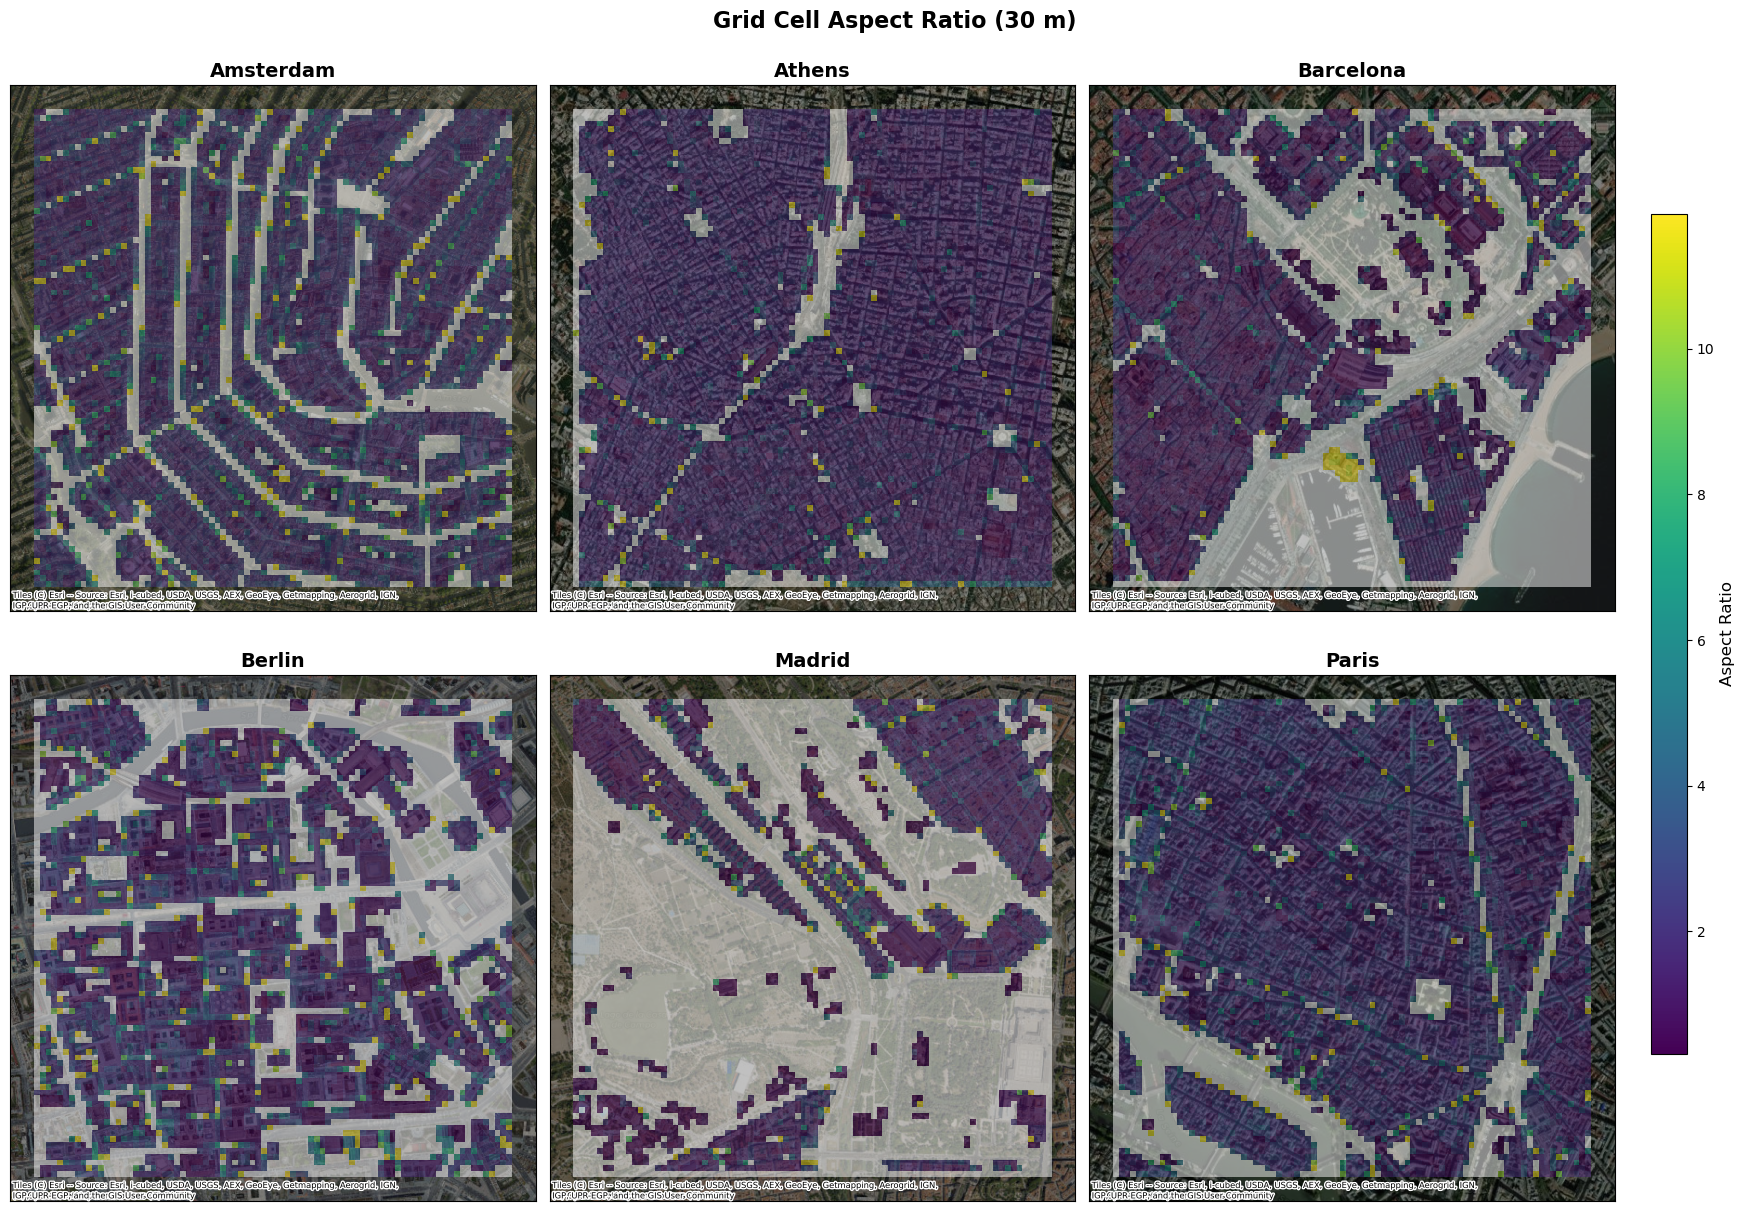

Saved aspect ratio figure to /Users/gerardoezequiel/Developer/ShapingCoolCities/results/figures/building_aspect_ratio_30m.png


In [12]:
# Visualisation of the aspect ratio at 30 m to see buildings in grid
if combined_grid_reference is None or combined_grid_reference.empty:
    print("No reference grid available for visualisation.")
else:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    vals = combined_grid_reference['aspect_ratio_weighted'].dropna()
    if vals.empty:
        print("Reference grid lacks aspect ratio data for plotting.")
    else:
        vmin, vmax = np.percentile(vals, [2, 98])
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mpl.cm.viridis
        threshold = 0.01

        for i, city in enumerate(CITIES):
            ax = axes[i]
            city_grid = combined_grid_reference[combined_grid_reference['city'] == city].copy()
            if not city_grid.empty:
                if city_grid.geometry.iloc[0].geom_type in ['Polygon', 'MultiPolygon']:
                    city_grid = city_grid.to_crs('EPSG:3857')
                vals = city_grid['aspect_ratio_weighted'].values
                colors = [
                    (1, 1, 1, 0) if (np.isnan(v) or abs(v) < threshold)
                    else (*cmap(norm(np.clip(v, vmin, vmax)))[:3], 0.5)
                    for v in vals
                ]
                city_grid.plot(
                    ax=ax, color=colors, edgecolor='none', alpha=0.5,
                    missing_kwds={"color": (1, 1, 1, 0), "label": "Missing"}
                )
                try:
                    ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter, crs=city_grid.crs, attribution_size=6)
                    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=city_grid.crs, alpha=0.5, attribution_size=6)
                except Exception:
                    pass
                ax.set_title(city, fontsize=14, fontweight='bold')
                ax.set_xticks([]); ax.set_yticks([])
            else:
                ax.text(0.5, 0.5, f'No data for {city}', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(city, fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.suptitle(f'Grid Cell Aspect Ratio ({reference_resolution} m)', fontsize=16, fontweight='bold', y=1.02)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        fig.colorbar(sm, cax=cbar_ax).set_label("Aspect Ratio", fontsize=12)
        plt.subplots_adjust(right=0.9)
        fig_path = FIG_DIR / f'building_aspect_ratio_{reference_resolution}m.png'
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f'Saved aspect ratio figure to {fig_path}')


## 5. Export

In [13]:
for grid_size, combined_grid in resolution_results.items():
    if combined_grid is None or combined_grid.empty:
        print(f"Resolution {grid_size} m: no data exported.")
        continue
    occupied = combined_grid['building_count'].gt(0).sum()
    total = len(combined_grid)
    pct = 100 * occupied / total if total else 0
    print(f"Resolution {grid_size} m: {occupied:,}/{total:,} cells with buildings ({pct:.1f}%)")

Resolution 30 m: 27,916/40,344 cells with buildings (69.2%)
Resolution 60 m: 7,969/10,086 cells with buildings (79.0%)
Resolution 90 m: 3,946/4,704 cells with buildings (83.9%)


In [14]:
pd.set_option('display.max_columns', None)
grid_30m = resolution_results.get(30)
cols = [c for c in grid_30m if c not in {'geometry', 'city', 'global_grid_id', 'grid_size_m', 'has_buildings'}]
desc = grid_30m[cols].describe(include='all')
desc = desc.drop(['top', 'freq', 'unique', 'count_unique'], errors='ignore')
display(desc)

building_count  total_footprint_area  total_wall_surface_area  \
count    40344.000000          27916.000000             27916.000000   
mean         2.227097            228.765138              1662.377162   
std          2.305376            134.073856              1077.464443   
min          0.000000              0.000013                 0.000000   
25%          0.000000            122.056426               914.830281   
50%          2.000000            235.644558              1605.568437   
75%          4.000000            326.469543              2316.032913   
max         15.000000           1079.347409             28640.742828   

                FAR           BVD  area_weighted_height  \
count  27916.000000  27916.000000          27916.000000   
mean       2.739122      8.609399             16.118926   
std        2.263921      7.563220              9.394985   
min        0.000000      0.000000              0.000000   
25%        1.317041      4.025352             13.645585   
50%        2.651054      8.183864             15.000000   
75%        3.786697     11.799801             18.160301   
max       72.000000    250.000000            250.000000   

       building_coverage_ratio  plan_porosity  height_std_weighted  \
count             2.791600e+04   27916.000000         27916.000000   
mean              5.261203e-01       0.473880             1.115361   
std               2.906805e-01       0.290680             2.113114   
min               3.939842e-08       0.000000             0.000000   
25%               2.960375e-01       0.239976             0.000000   
50%               5.523410e-01       0.447659             0.052510   
75%               7.600236e-01       0.703963             1.520902   
max               1.000000e+00       1.000000           103.483734   

         height_p10    height_p90  height_range  height_relative  \
count  27916.000000  27916.000000  27916.000000     2.791600e+04   
mean      14.504106     17.342758      3.676530     1.060592e-01   
std        9.382142      9.592565      6.249373     2.305385e+00   
min        0.000000      0.000000      0.000000    -1.105714e+02   
25%       11.250000     15.000000      0.000000    -3.552714e-15   
50%       15.000000     16.009175      0.300000     0.000000e+00   
75%       16.300000     19.960000      5.200000     4.976889e-02   
max      250.000000    250.000000    232.500000     8.754170e+01   

       aspect_ratio_weighted  compactness_weighted  wall_to_plan_ratio  \
count           27916.000000          27916.000000        27916.000000   
mean                3.507692              0.048169           19.458020   
std                41.423061              0.010316          261.712797   
min                 0.000000              0.001356            0.000000   
25%                 1.259358              0.042548            5.792765   
50%                 1.692678              0.049844            7.911434   
75%                 2.241276              0.055610           10.682386   
max              4248.438603              0.077536        24655.459567   

       frontal_area_index  surface_to_volume_ratio  thermal_mass_index  \
count        27916.000000             27916.000000        27916.000000   
mean             3.904840                 1.231651            0.325588   
std              2.493342                15.176741            0.067120   
min              0.000000                 0.000000            0.000000   
25%              2.171651                 0.380777            0.307692   
50%              3.762327                 0.511238            0.322581   
75%              5.257006                 0.679568            0.333333   
max             56.572900              1475.388792            7.142857   

       facade_orientation_entropy  canyon_width_mean  courtyard_fraction  \
count                27916.000000       27916.000000        27916.000000   
mean                     0.366575           9.334825            0.008794   
std                 

In [15]:
grid_30m.columns


Index(['geometry', 'city', 'global_grid_id', 'grid_size_m', 'building_count',
       'total_footprint_area', 'total_wall_surface_area', 'FAR', 'BVD',
       'area_weighted_height', 'building_coverage_ratio', 'plan_porosity',
       'height_std_weighted', 'height_p10', 'height_p90', 'height_range',
       'height_relative', 'aspect_ratio_weighted', 'compactness_weighted',
       'wall_to_plan_ratio', 'frontal_area_index', 'surface_to_volume_ratio',
       'thermal_mass_index', 'facade_orientation_entropy', 'canyon_width_mean',
       'courtyard_fraction', 'area_weighted_building_year',
       'age_pre1950_share', 'age_1950_1990_share', 'age_post1990_share',
       'frontal_area_density_ns', 'frontal_area_density_ew', 'has_buildings'],
      dtype='object')